In [78]:
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)

# Load data

In [79]:
#Loading the dataset
data = pd.read_csv("marketing_campaign.csv", sep="\t")
print("Number of datapoints:", len(data))
data.head()

Number of datapoints: 2240


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


# About the data

## Customer's Information
ID, Year_Birth, Education, Marital_Status, Income, Kidhome, Teenhome, Dt_Customer, Recency, Complain

### The dataset consists of 2240 datapoints and 29 attributes
### Products
Amount spent on different products in last 2 years.
* MntWines
* MntFruits
* MntMeatProducts
* MntFishProducts
* MntSweetProducts
* MntGoldProds

Promotion
* NumDealsPurchases
* AcceptedCmp1
* AcceptedCmp?
* AcceptedCmp3
* AcceptedCmp4
* AcceptedCmp5
* Response

Place
* NumWebPurchases
* NumCatalogPurchases
* NumStorePurchases
* NumWebVisitsMonth

# Data cleaning

In [80]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

Observations
- Income is missing values. Solution: drop those rows
- Dt_Customer not parsed as a DateTime. Solution: parse as DT
- There are some categorical features. Sol: encode them into numeric forms


In [81]:
# Remove NaN values
data = data.dropna()
print(f"New dataset size: {data.shape}")

New dataset size: (2216, 29)


Convert "Dt_Customer" to indicate the number of days a customer is registered in the firm's database relative to the most recent customer in the record.

In [82]:
data["Dt_Customer"] = pd.to_datetime(data["Dt_Customer"], format='mixed')
dates = []

for i in data["Dt_Customer"]:
    i = i.date()
    dates.append(i)

print(dates[:10])

#Dates of the newest and oldest recorded customer
print("The newest customer's enrolment date in the records:", max(dates))
print("The oldest customer's enrolment date in the records:", min(dates))

[datetime.date(2012, 4, 9), datetime.date(2014, 8, 3), datetime.date(2013, 8, 21), datetime.date(2014, 10, 2), datetime.date(2014, 1, 19), datetime.date(2013, 9, 9), datetime.date(2012, 11, 13), datetime.date(2013, 8, 5), datetime.date(2013, 6, 6), datetime.date(2014, 3, 13)]
The newest customer's enrolment date in the records: 2014-12-06
The oldest customer's enrolment date in the records: 2012-01-08


In [91]:
# Number of days
days = []
d1 = max(dates)
for i in dates:
    delta = d1 - i
    days.append(delta)
data["Customer_For"] = days
data["Customer_For"] = data["Customer_For"].apply(lambda x: x.days)
print(data["Customer_For"].describe())

count    2216.000000
mean      512.006318
std       232.469034
min         0.000000
25%       340.000000
50%       513.000000
75%       686.000000
max      1063.000000
Name: Customer_For, dtype: float64


In [92]:
# Now explore the categorical features
print("Total categories in the feature Marital_Status:\n", data["Marital_Status"].value_counts(), "\n")
print("Total categories in the feature Education:\n", data["Education"].value_counts())

Total categories in the feature Marital_Status:
 Marital_Status
Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64 

Total categories in the feature Education:
 Education
Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: count, dtype: int64


### Next, engineer some new features:
- Extract the "Age" of a customer by the "Year_Birth" indicating the birth year of the respective person.
- Create another feature "Spent" indicating the total amount spent by the customer in various categories over the span of two years.
- Create another feature "Living_With" out of "Marital_Status" to extract the living situation of couples.
- reate a feature "Children" to indicate total children in a household that is, kids and teenagers.
- To get further clarity of household, Creating feature indicating "Family_Size"
- Create a feature "Is_Parent" to indicate parenthood status
- Lastly, I will create three categories in the "Education" by simplifying its value counts.
Dropping some of the redundant features


In [93]:
# Feature engineering
# Age of customer today
data["Age"] = 2024 - data["Year_Birth"]

# Total spendings on various items
data["Spent"] = data["MntWines"] + data["MntFruits"] + data["MntMeatProducts"] + data["MntFishProducts"] + data["MntSweetProducts"] + data["MntGoldProds"]

# Derive living situation by marital status
data["Living_With"] = data["Marital_Status"].replace({"Married": "Partner", 
                                                      "Together": "Partner", 
                                                      "Absurd": "Alone", 
                                                      "Widow": "Alone", 
                                                      "YOLO": "Alone", 
                                                      "Divorced": "Alone", 
                                                      "Single": "Alone"})

# Feature indicating total children living in household
data["Children"] = data["Kidhome"] + data["Teenhome"]

# Feature indicating total number of family members
data["Family_Size"] = data["Living_With"].replace({"Alone": 1, 
                                                   "Partner": 2}) + \
                      data["Children"]

# Feature indicating parental status
data["Is_Parent"] = np.where(data.Children > 0, 1, 0)

# Segment education levels into three groups
data["Education"] = data["Education"].replace({"Basic": "Undergraduate",
                                               "2n Cycle": "Undergraduate",
                                               "Graduation": "Graduate",
                                               "Master": "Postgraduate",
                                               "PhD": "Postgraduate"})

# Clarify the meaning of certain columns
data = data.rename(columns={"MntWines": "Wines",
                            "MntFruits": "Fruits",
                            "MntMeatProducts": "Meat",
                            "MntFishProducts": "Fish",
                            "MntSweetProducts": "Sweets",
                            "MntGoldProds": "Gold"})

# Drop redundant columns
to_drop = ["Marital_Status", "Dt_Customer", "Z_CostContact", 
         "Z_Revenue", "Year_Birth", "ID"]
data = data.drop(to_drop, axis=1)

In [94]:
# Take a look at the dataset
data.describe()

,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,...,AcceptedCmp1,AcceptedCmp2,Complain,Response,Customer_For,Age,Spent,Children,Family_Size,Is_Parent
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,...,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,52247.251354,0.441787,0.505415,49.012635,305.091606,26.356047,166.995939,37.637635,27.028881,43.965253,...,0.064079,0.013538,0.009477,0.150271,512.006318,55.179603,607.075361,0.947202,2.592509,0.714350
std,25173.076661,0.536896,0.544181,28.948352,337.327920,39.793917,224.283273,54.752082,41.072046,51.815414,...,0.244950,0.115588,0.096907,0.357417,232.469034,11.985554,602.900476,0.749062,0.905722,0.451825
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,28.000000,5.000000,0.000000,1.000000,0.000000
25%,35303.000000,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,...,0.000000,0.000000,0.000000,0.000000,340.000000,47.000000,69.000000,0.000000,2.000000,0.000000
50%,51381.500000,0.000000,0.000000,49.000000,174.500000,8.000000,68.000000,12.000000,8.000000,24.500000,...,0.000000,0.000000,0.000000,0.000000,513.000000,54.000000,396.500000,1.000000,3.000000,1.000000
75%,68522.000000,1.000000,1.000000,74.000000,505.000000,33.000000,232.250000,50.000000,33.000000,56.000000,...,0.000000,0.000000,0.000000,0.000000,686.000000,65.000000,1048.000000,1.000000,3.000000,1.000000
max,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,...,1.000000,1.000000,1.000000,1.000000,1063.000000,131.000000,2525.000000,3.000000,5.000000,1.000000


Observations:
 - Discrepancies in Age and Income
    - Max age should not be 131

<Figure size 800x550 with 0 Axes>

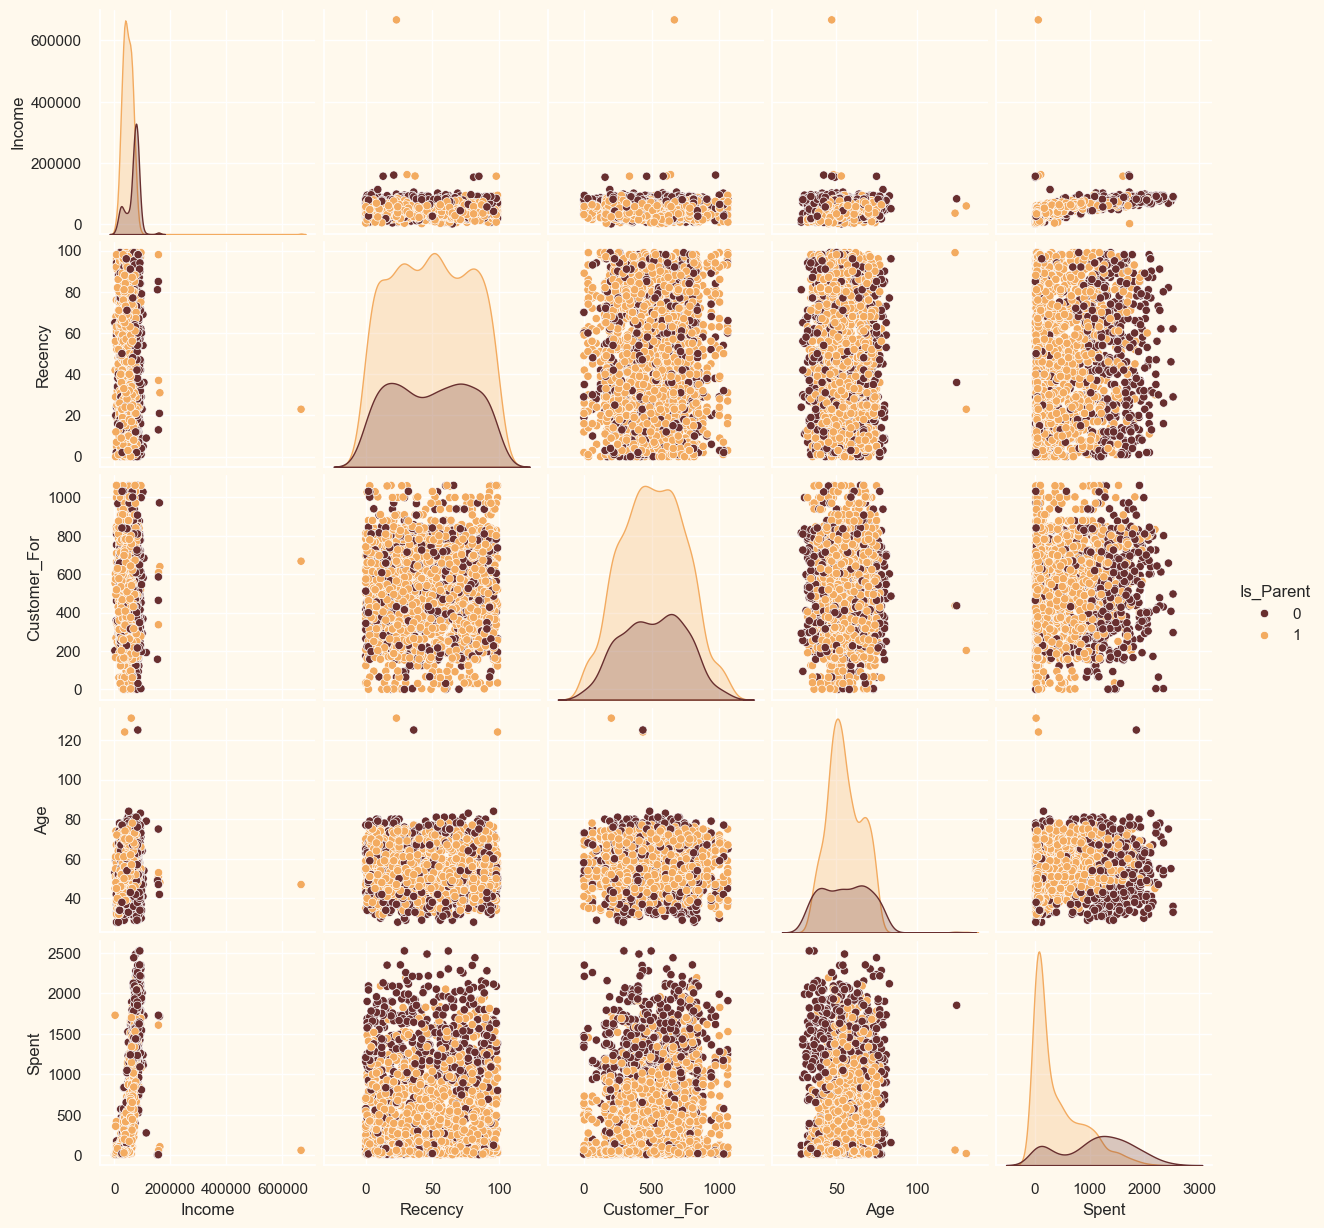

In [95]:
# Plot some selected features
# Set some nice colors
sns.set_theme(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})
pallet = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])

# Plot
to_plot = ['Income','Recency','Customer_For','Age','Spent','Is_Parent']
plt.figure()
sns.pairplot(data[to_plot], hue="Is_Parent", palette=["#682F2F", "#F3AB60"])
plt.show()

Observation:
- There are outliers in Income and Age to remove

In [96]:
#Dropping the outliers by setting a cap on Age and income. 
data = data[(data["Age"]<90)]
data = data[(data["Income"]<600000)]
print("The total number of data-points after removing the outliers are:", len(data))

The total number of data-points after removing the outliers are: 2212


<Axes: >

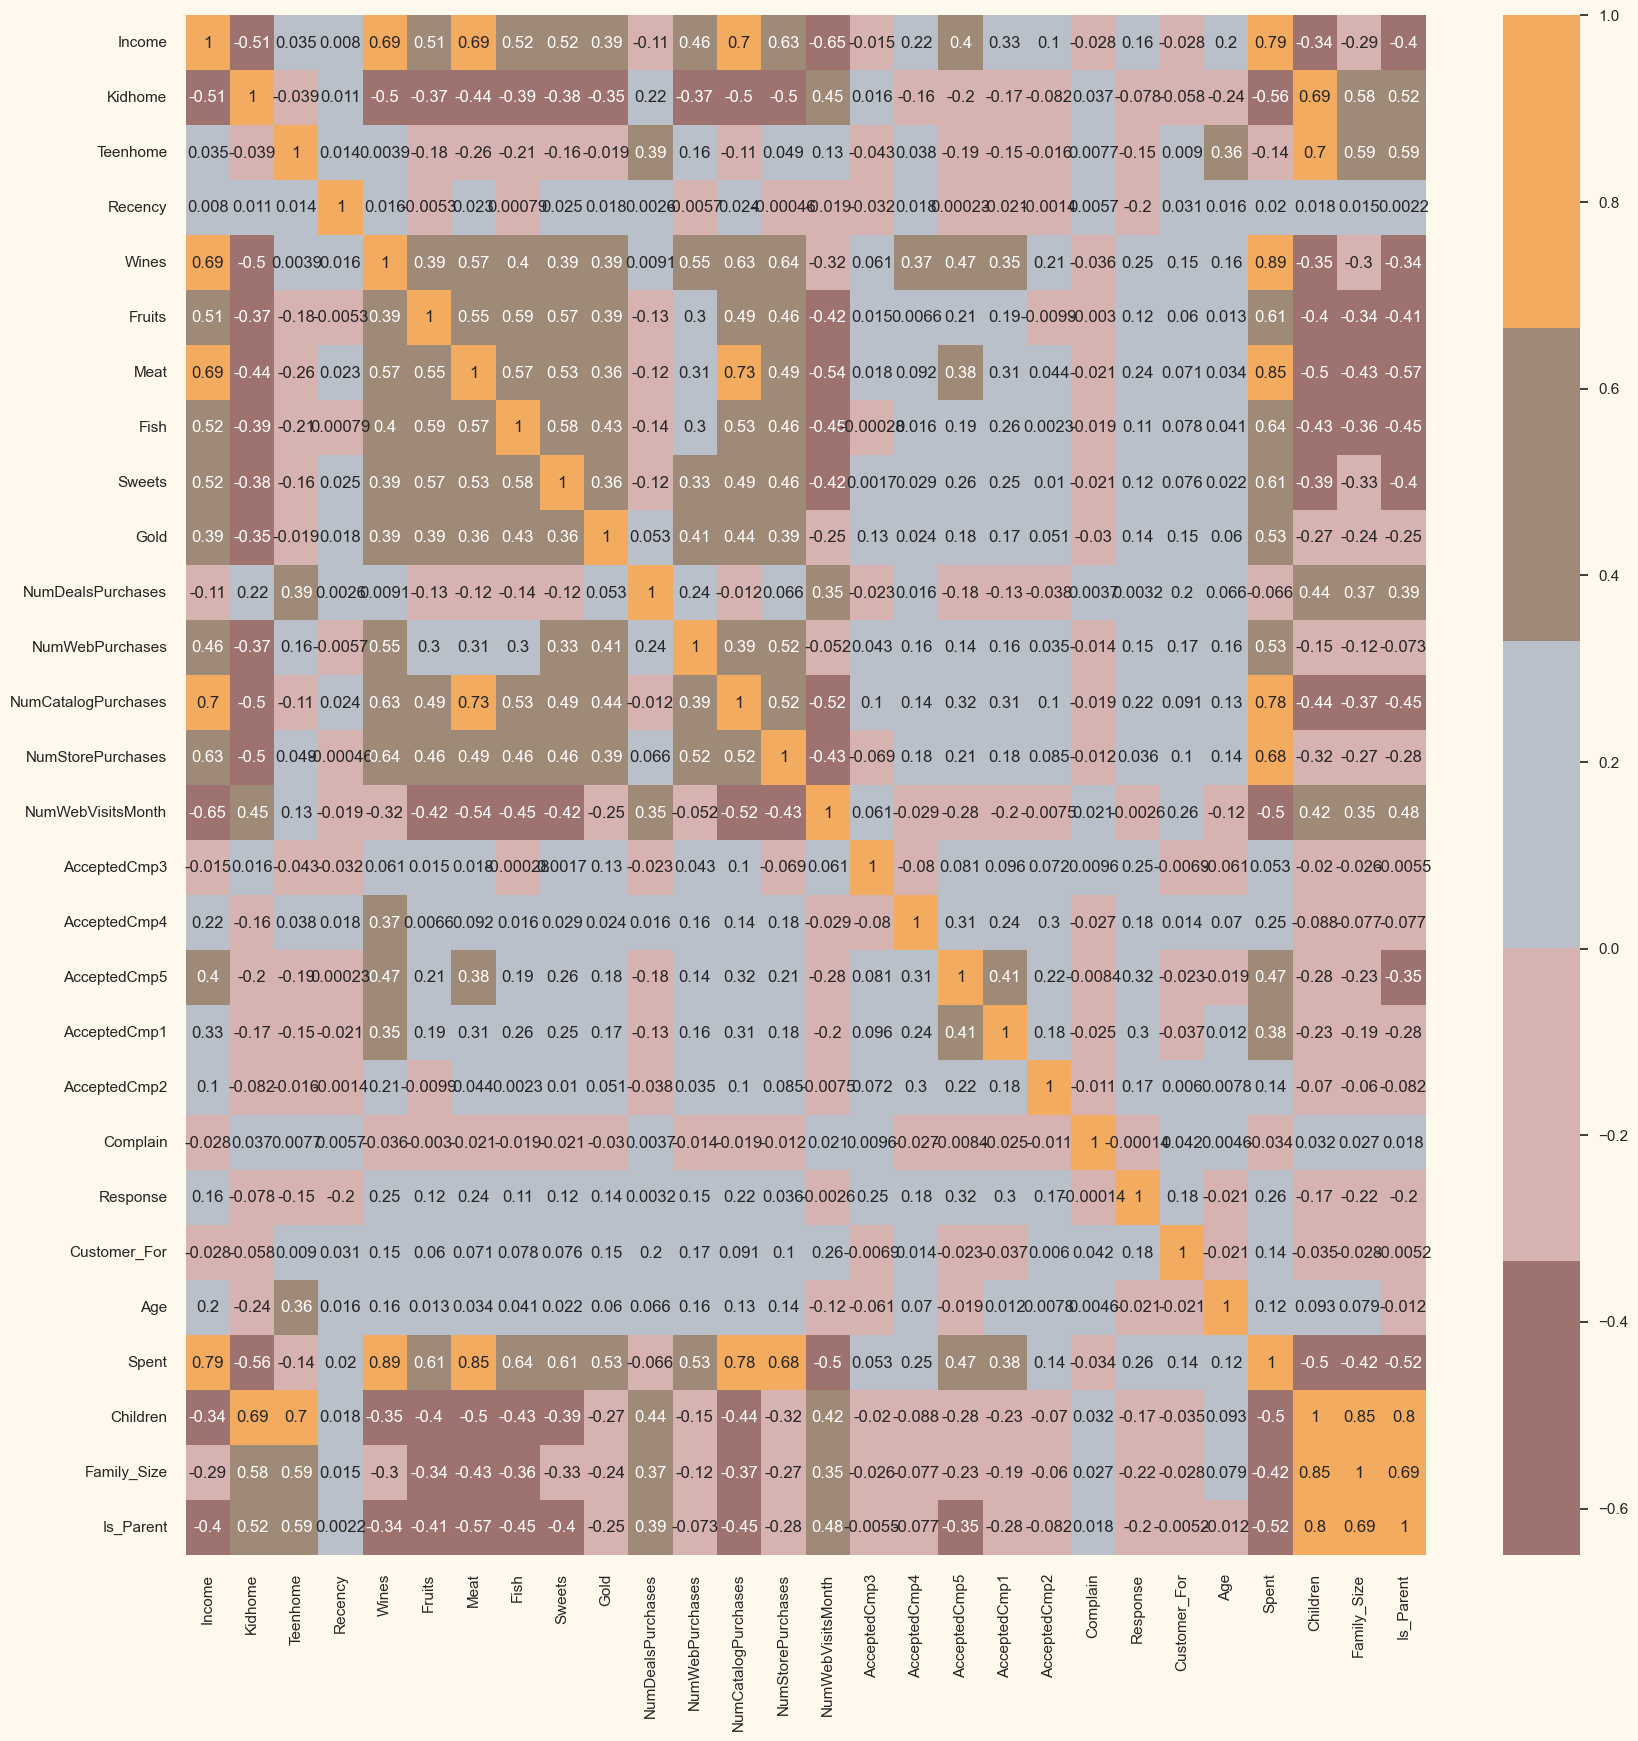

In [97]:
# Let's take a look at correlations between features, excluding categorical features
#correlation matrix
corrmat= data.corr(numeric_only=True)
plt.figure(figsize=(20,20))  
sns.heatmap(corrmat,annot=True, cmap=cmap, center=0)

# Data preprocessing

Steps
- Label encode the categorical features
- Scale the featues w/ standard scaler
- Create subset dataframe for dimensionality reduction

In [98]:
# Get list of categorical variables
s = (data.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables in the dataset:", object_cols)

Categorical variables in the dataset: ['Education', 'Living_With']


In [99]:
# Label encoding the object dtypes
LE=LabelEncoder()
for i in object_cols:
    data[i]=LE.fit_transform(data[i])
     
print("All features are now numerical")
data.info()

All features are now numerical
<class 'pandas.core.frame.DataFrame'>
Index: 2212 entries, 0 to 2239
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Education            2212 non-null   int64  
 1   Income               2212 non-null   float64
 2   Kidhome              2212 non-null   int64  
 3   Teenhome             2212 non-null   int64  
 4   Recency              2212 non-null   int64  
 5   Wines                2212 non-null   int64  
 6   Fruits               2212 non-null   int64  
 7   Meat                 2212 non-null   int64  
 8   Fish                 2212 non-null   int64  
 9   Sweets               2212 non-null   int64  
 10  Gold                 2212 non-null   int64  
 11  NumDealsPurchases    2212 non-null   int64  
 12  NumWebPurchases      2212 non-null   int64  
 13  NumCatalogPurchases  2212 non-null   int64  
 14  NumStorePurchases    2212 non-null   int64  
 15  NumWebVisits

In [100]:
# Copy the data 
ds = data.copy()

# Create subset of df by dropping the features related to deals
cols_del = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 
            'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response']
ds = ds.drop(cols_del, axis=1)

# Scaling the data
scaler = StandardScaler()
scaler.fit(ds)
scaled_ds = pd.DataFrame(scaler.transform(ds),columns= ds.columns )
print("All features are now scaled")

All features are now scaled


In [101]:
#Scaled data to be used for reducing the dimensionality
print("Dataframe to be used for further modelling:")
scaled_ds.head()

Dataframe to be used for further modelling:


,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Customer_For,Age,Spent,Living_With,Children,Family_Size,Is_Parent
0,-0.893586,0.287105,-0.822754,-0.929699,0.310353,0.977660,1.552041,1.690293,2.453472,1.483713,...,2.503607,-0.555814,0.692181,1.973583,1.018352,1.676245,-1.349603,-1.264598,-1.758359,-1.581139
1,-0.893586,-0.260882,1.040021,0.908097,-0.380813,-0.872618,-0.637461,-0.718230,-0.651004,-0.634019,...,-0.571340,-1.171160,-0.132545,-1.665144,1.274785,-0.963297,-1.349603,1.404572,0.449070,0.632456
2,-0.893586,0.913196,-0.822754,-0.929699,-0.795514,0.357935,0.570540,-0.178542,1.339513,-0.147184,...,-0.229679,1.290224,-0.544908,-0.172664,0.334530,0.280110,0.740959,-1.264598,-0.654644,-1.581139
3,-0.893586,-1.176114,1.040021,-0.929699,-0.795514,-0.872618,-0.561961,-0.655787,-0.504911,-0.585335,...,-0.913000,-0.555814,0.279818,-1.923210,-1.289547,-0.920135,0.740959,0.069987,0.449070,0.632456
4,0.571657,0.294307,1.040021,-0.929699,1.554453,-0.392257,0.419540,-0.218684,0.152508,-0.001133,...,0.111982,0.059532,-0.132545,-0.822130,-1.033114,-0.307562,0.740959,0.069987,0.449070,0.632456


# Dimensionality Reduction
Motivation:

The higher the number of features, the harder it is to work with it. Many of these features are correlated, and hence redundant.

Dimensionality reduction is the process of reducing the number of random variables under consideration, by obtaining a set of principal variables.

Principal component analysis (PCA) is a technique for reducing the dimensionality of such datasets, increasing interpretability but at the same time minimizing information loss.

Steps:
- Dimensionality reduction with PCA
- Plotting the reduced dataframe
- Dimensionality reduction with PCA


In [125]:
#Initiating PCA to reduce dimencions aka features to 3
pca = PCA(n_components=3)
pca.fit(scaled_ds)
PCA_ds = pd.DataFrame(pca.transform(scaled_ds), columns=(["col1","col2", "col3"]))
PCA_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,2212.0,-6.424437e-17,2.878377,-5.969394,-2.538494,-0.780421,2.383290,7.444305
col2,2212.0,7.066881e-17,1.706839,-4.312182,-1.328322,-0.158129,1.242288,6.142725
col3,2212.0,2.971302e-17,1.221957,-3.530487,-0.828816,-0.021929,0.799398,6.615126


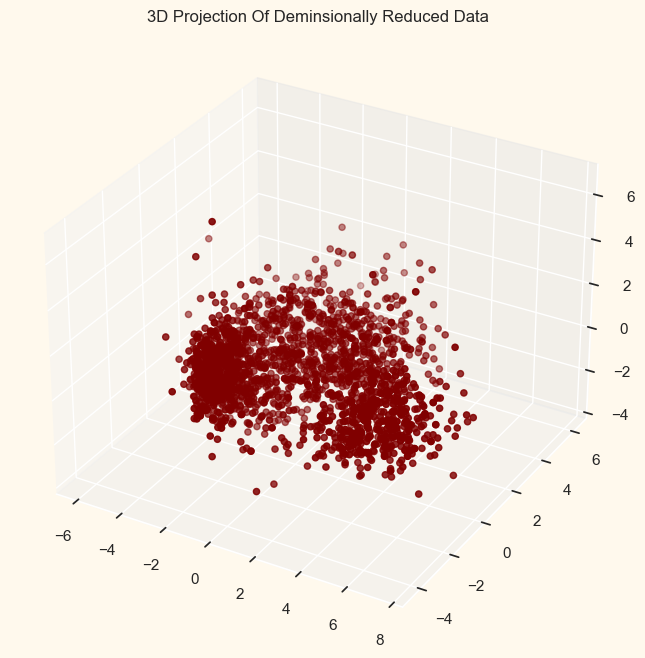

In [126]:
#A 3D Projection Of Data In The Reduced Dimension
x =PCA_ds["col1"]
y =PCA_ds["col2"]
z =PCA_ds["col3"]

#To plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="maroon", marker="o" )
ax.set_title("3D Projection Of Deminsionally Reduced Data")
plt.show()

# Clustering
Now that the data have been reduced to three dimensions, we perform clustering. We will compare hand-built K-means clustering to Agglomerative clustering. Agglomerative clustering is a hierarchical clustering method. It involves merging examples until the desired number of clusters is achieved.

Steps:
- Elbow Method to determine the number of clusters to be formed
- Clustering via Agglomerative Clustering
- Examining the clusters formed via scatter plot


Elbow Method to determine the number of clusters to be formed:


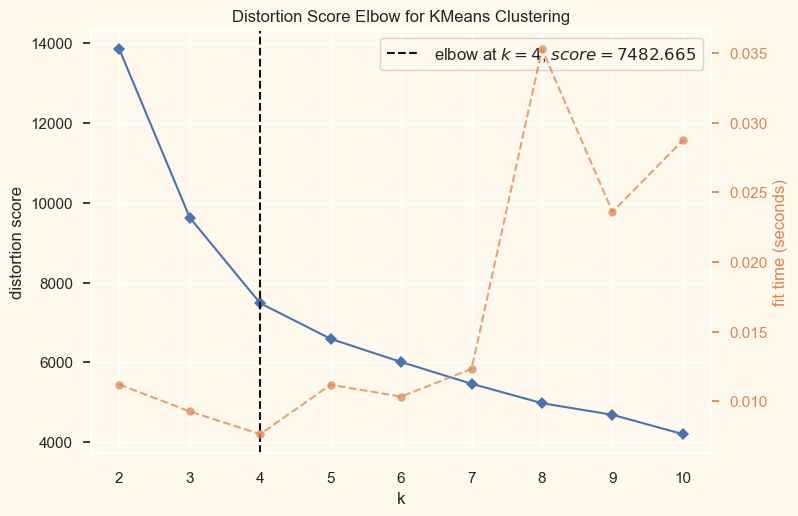

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [127]:
# Quick examination of elbow method to find numbers of clusters to make.
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(PCA_ds)
Elbow_M.show()

In [128]:
# Four is the optimal number of clusters

#Initiating the Agglomerative Clustering model 
AC = AgglomerativeClustering(n_clusters=4)
# fit model and predict clusters
yhat_AC = AC.fit_predict(PCA_ds)
PCA_ds["Clusters"] = yhat_AC

#Adding the Clusters feature to the orignal dataframe.
data["Clusters"]= yhat_AC

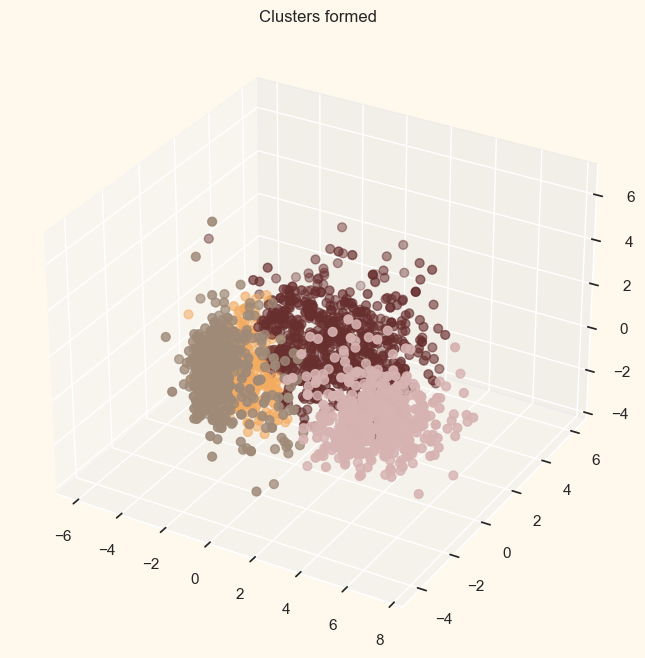

In [129]:
# Examine clusters formed
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=PCA_ds["Clusters"], marker='o', cmap = cmap )
ax.set_title("Clusters formed")
plt.show()

# Model evaluation
Since this is an unsupervised clustering, we do not have a tagged feature to evaluate or score our model. The purpose of this section is to study the patterns in the clusters formed and determine the nature of the clusters' patterns.

For that, we will look at the data in light of clusters via exploratory data analysis and by drawing conclusions.

Firstly, we look at the group distribution of clustring


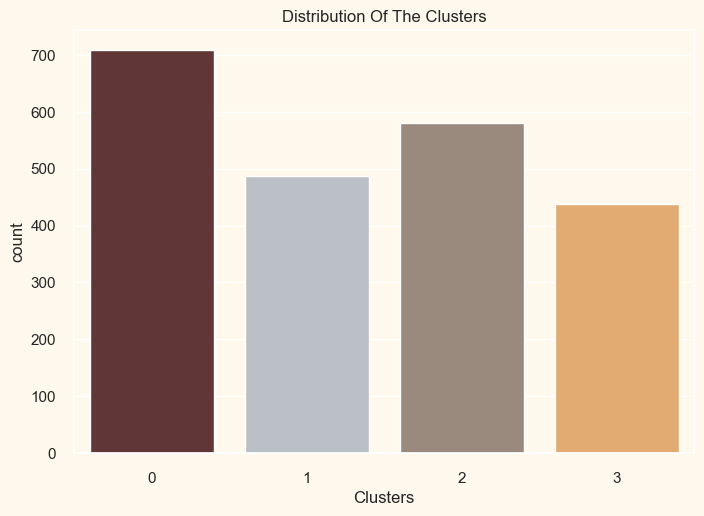

In [132]:
#Plotting countplot of clusters
pal = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60"]
pl = sns.countplot(x=data["Clusters"], palette= pal)
pl.set_title("Distribution Of The Clusters")
plt.show()


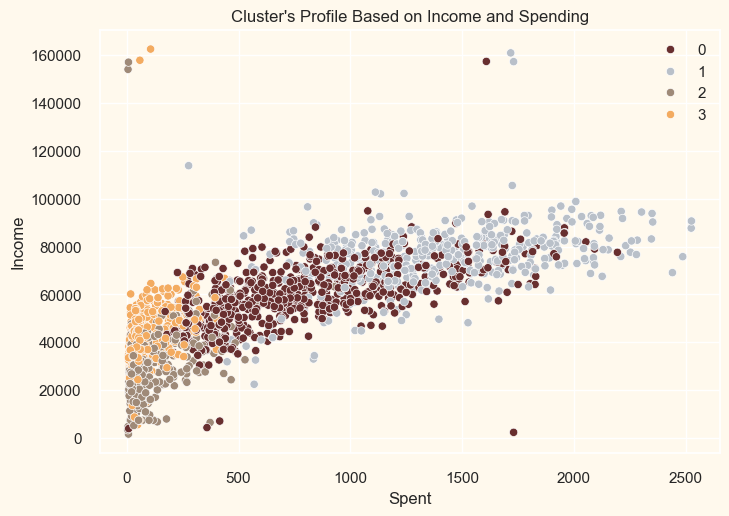

In [133]:
pl = sns.scatterplot(data = data,x=data["Spent"], y=data["Income"],hue=data["Clusters"], palette= pal)
pl.set_title("Cluster's Profile Based on Income and Spending")
plt.legend()
plt.show()

### Income vs spending plot shows the clusters pattern

- Group 0: high spending & average income
- Group 1: high spending & high income
- Group 2: low spending & low income
- Group 3: high spending & low income


Next, let's look at the detailed distribution of clusters as per the various products in the data. Namely: Wines, Fruits, Meat, Fish, Sweets and Gold

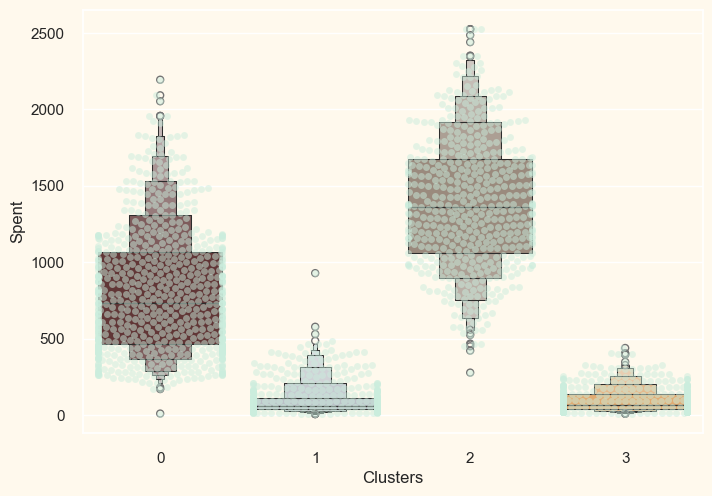

In [120]:
plt.figure()
pl=sns.swarmplot(x=data["Clusters"], y=data["Spent"], color= "#CBEDDD", alpha=0.5 )
pl=sns.boxenplot(x=data["Clusters"], y=data["Spent"], palette=pal)
plt.show()

Observation: 
- Clusters 2 and 0 are the largest set of customers.
- We can explore what each group is spending on for the targeted marketing strategies

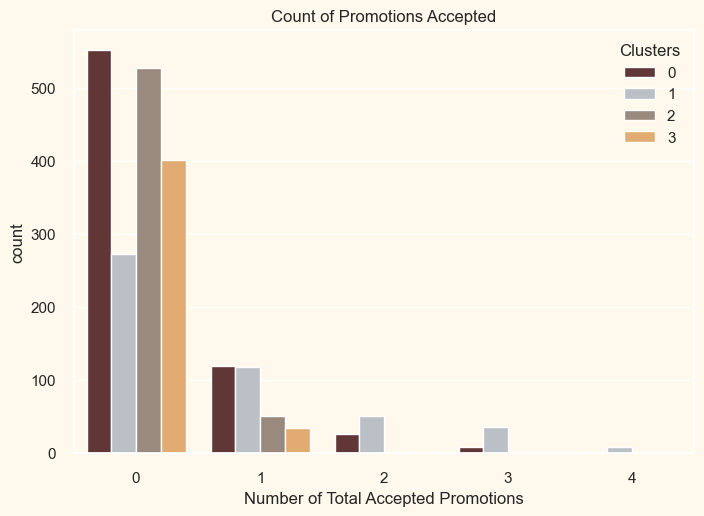

In [135]:
#Creating a feature to get a sum of accepted promotions 
data["Total_Promos"] = data["AcceptedCmp1"]+ data["AcceptedCmp2"]+ data["AcceptedCmp3"]+ data["AcceptedCmp4"]+ data["AcceptedCmp5"]
#Plotting count of total campaign accepted.
plt.figure()
pl = sns.countplot(x=data["Total_Promos"],hue=data["Clusters"], palette= pal)
pl.set_title("Count of Promotions Accepted")
pl.set_xlabel("Number of Total Accepted Promotions")
plt.show()

#### Observation: 

There has not been an overwhelming response to the campaigns so far. Very few participants overall. Moreover, no one part take in all 5 of them. Perhaps better-targeted and well-planned campaigns are required to boost sales.

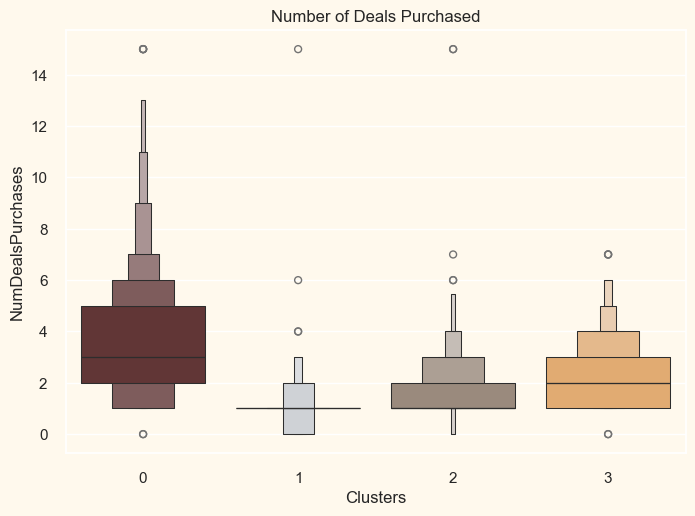

In [136]:
#Plotting the number of deals purchased
plt.figure()
pl=sns.boxenplot(y=data["NumDealsPurchases"],x=data["Clusters"], palette= pal)
pl.set_title("Number of Deals Purchased")
plt.show()

#### Observation
Unlike campaigns, the deals offered did well. It had the best outcome with clusters 0 and 3. However, our star customers in cluster 2 are not much into the deals. Nothing seems to attract cluster 2 overwhelmingly.

# Profiling

Now that we have formed the clusters and looked at their purchasing habits, let's see who's in these clusters. For that, we will be profiling the clusters formed and come to a conclusion about who is our star customer and who needs more attention from the retail store's marketing team.

To decide that, let's plot some of the features that are indicative of the customer's personal traits in light of the cluster they are in.

 Then, we can form some conclusions.


<Figure size 800x550 with 0 Axes>

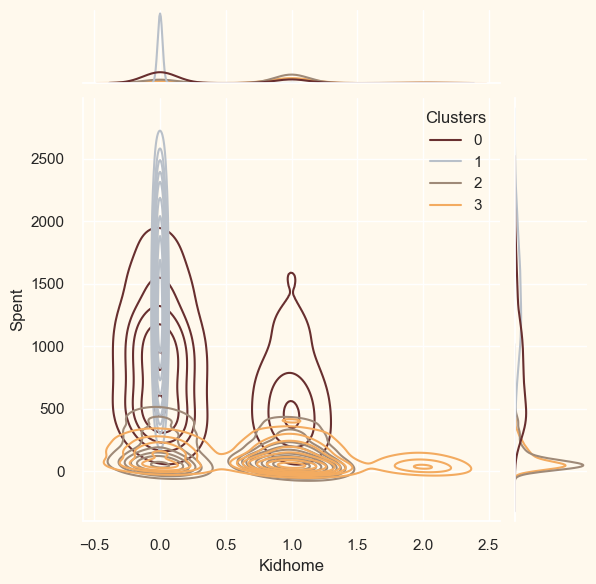

<Figure size 800x550 with 0 Axes>

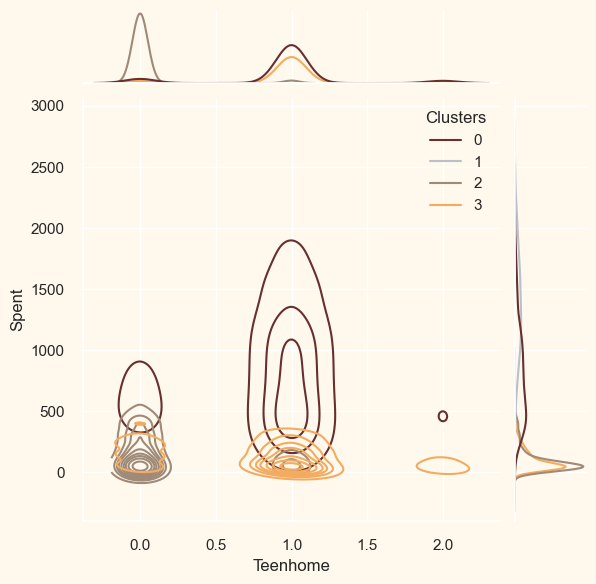

<Figure size 800x550 with 0 Axes>

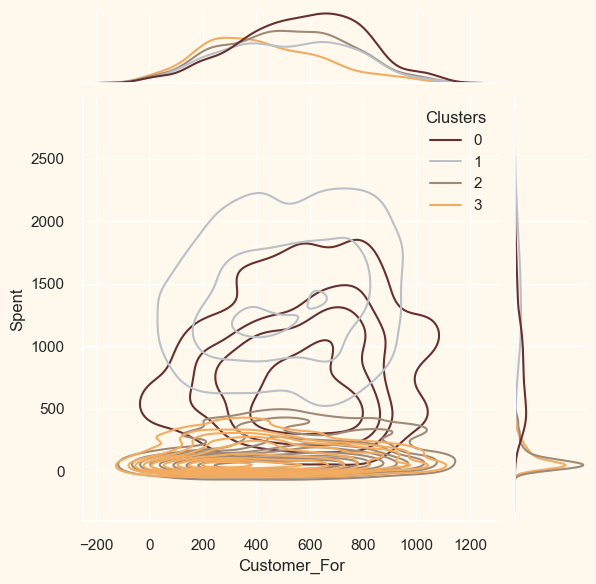

<Figure size 800x550 with 0 Axes>

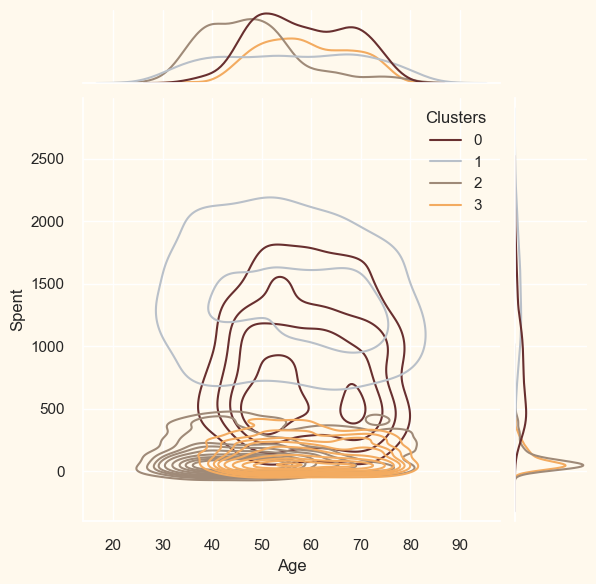

<Figure size 800x550 with 0 Axes>

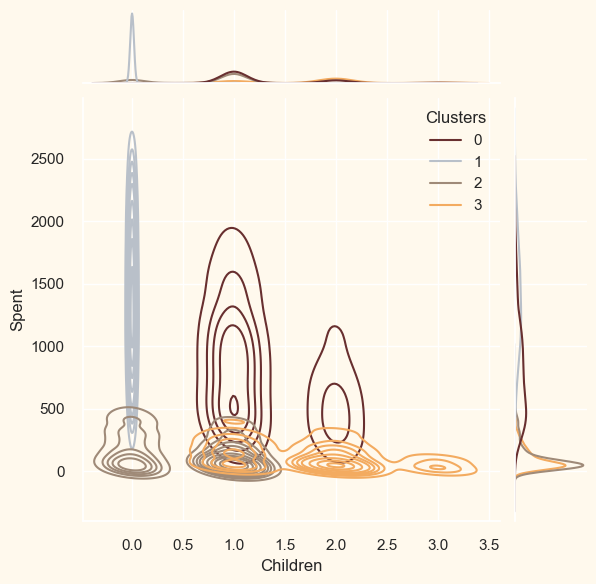

<Figure size 800x550 with 0 Axes>

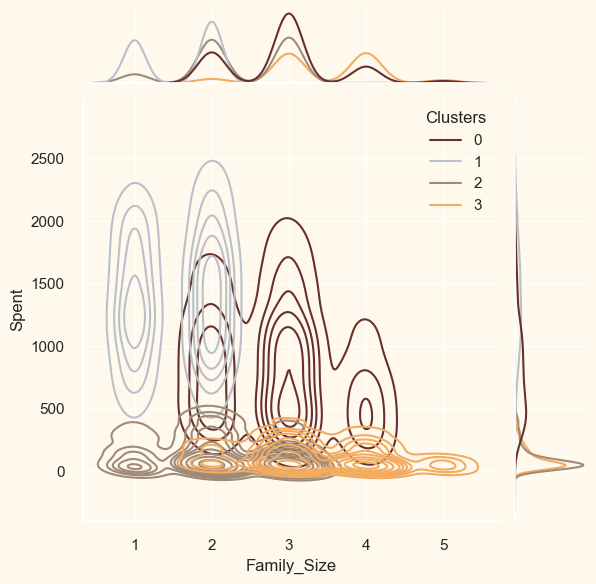

<Figure size 800x550 with 0 Axes>

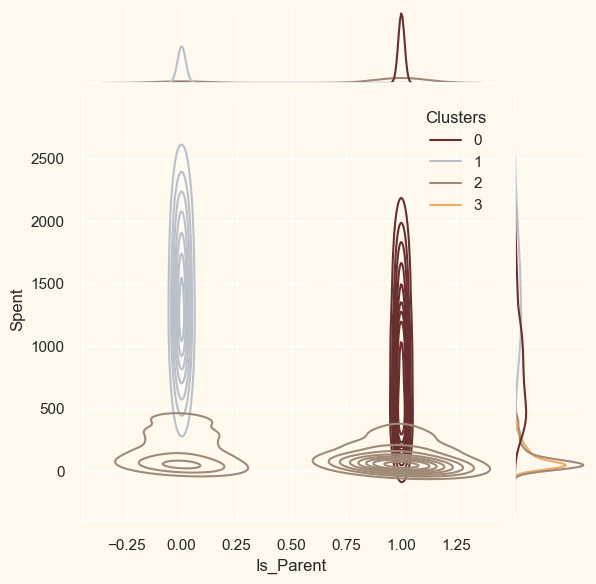

<Figure size 800x550 with 0 Axes>

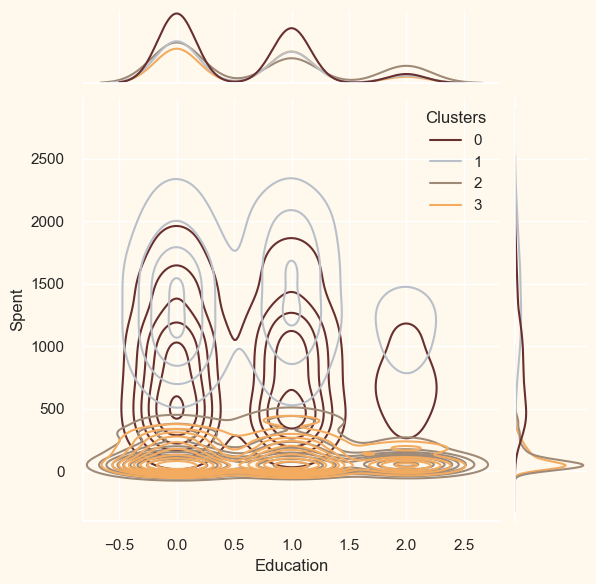

<Figure size 800x550 with 0 Axes>

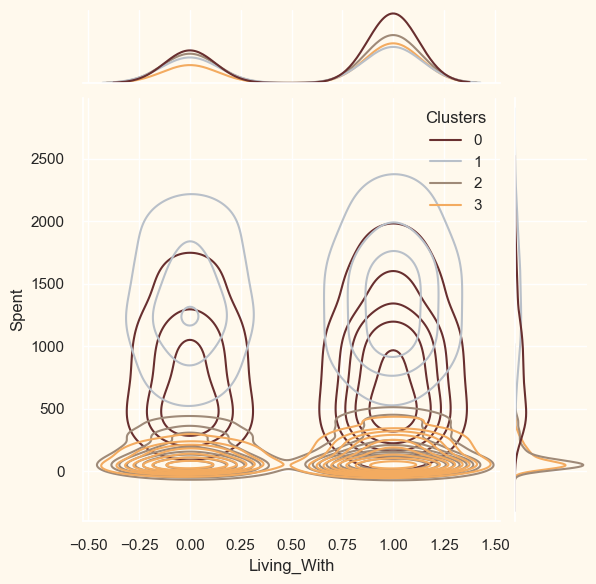

In [134]:
Personal = [ "Kidhome","Teenhome","Customer_For", "Age", "Children", "Family_Size", "Is_Parent", "Education","Living_With"]

for i in Personal:
    plt.figure()
    sns.jointplot(x=data[i], y=data["Spent"], hue =data["Clusters"], kind="kde", palette=pal)
    plt.show()

# Conclusion:

## Cluster 0 Profile:
- Definitely parents
- At least 2 family members, at the max 4
- Single parents are a subset of this group
- Most have a teenager at home
- Relatively older

## Cluster 1 Profile:
- Definitely not parents
- At max only two members
- Slight majority of couples over single people
- Span all ages
- High income

## Cluster 2 Profile:
- Majority are parents
- At max 3 members of family
- Typically have kids over teenagers
- Relatively younger

## Cluster 3 Profile:
- Definitely not parents
- At least 2 members of family, at max 5
- Majority have a teenager at home
- Relatively older
- Lower-income group

## This clustering reveals information about family structures and income/spending. Grocery store marketing can benefit from such insights to improve deals and offer target groups.